<a href="https://colab.research.google.com/github/sameertipnis/AlgoTrading/blob/main/Lecture_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agenda 
<ul>
  <li>Review of third lecture</li>
  <li>Time Series Modelling</li>
  <ul>
    <li>Staionary
    <li>CoIntegration - Pairs Trading </li>
  </ul>
  

In [ ]:
import numpy as np
import pandas as pd

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Time Series
# Random Time Series ( Every value is independent )
# [Random Walk](https://www.amazon.com/Random-Walk-Down-Wall-Street/dp/0393358380/ref=sr_1_1?gclid=Cj0KCQjw5ZSWBhCVARIsALERCvwPLjZzplCDooxy2KdW9EGpwrjywCH1AmYszmPJ55IiSBMVke0rLycaAqhQEALw_wcB&hvadid=241655275114&hvdev=c&hvlocphy=9003944&hvnetw=g&hvqmt=e&hvrand=15087445086105062917&hvtargid=kwd-58042426&hydadcr=21931_10172155&keywords=a+random+walk+down+wall+street&qid=1657146615&sr=8-1) 
# Stationary Time Series

# Calculus of Random and Discrete Variable -> Stochastic Calculus
[Steve Shreve](https://en.wikipedia.org/wiki/Steven_E._Shreve)

#Stationarity/Non-Stationarity

A commonly untested assumption in time series analysis is the stationarity of the data. Data are stationary when the parameters of the data generating process do not change over time. As an example, let's consider two series, A and B. Series A is generated from a stationary process with fixed parameters, series B is generated with parameters that change over time.

In [ ]:
def generate_datapoint(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

###Series A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


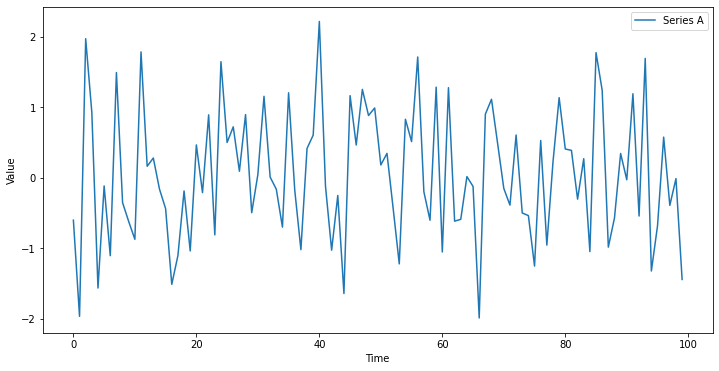

In [ ]:
# Set the parameters and the number of datapoints
plt.rcParams['figure.figsize'] = 12, 6
params = (0, 1)
T = 100

A = pd.Series(index=range(T))
A.name = 'A'

for t in range(T):
    A[t] = generate_datapoint(params)

plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

###Series B

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


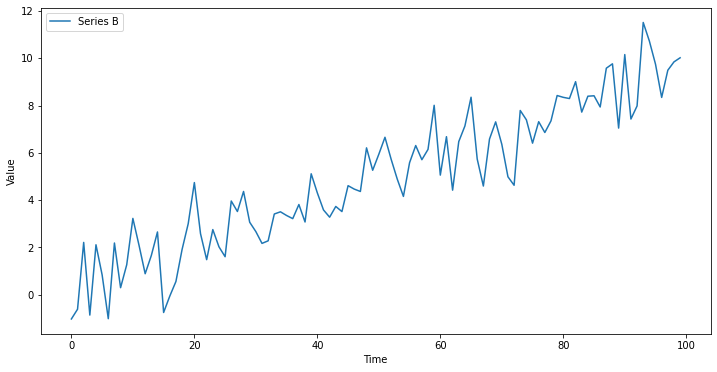

In [ ]:
# Set the number of datapoints
plt.rcParams['figure.figsize'] = 12, 6
T = 100

B = pd.Series(index=range(T))
B.name = 'B'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (t * 0.1, 1)
    B[t] = generate_datapoint(params)

plt.plot(B)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B']);

###Why Non-Stationarity is Dangerous

Many statistical tests, deep down in the fine print of their assumptions, require that the data being tested are stationary. Also, if you naively use certain statistics on a non-stationary data set, you will get garbage results. As an example, let's take an average through our non-stationary $B$.

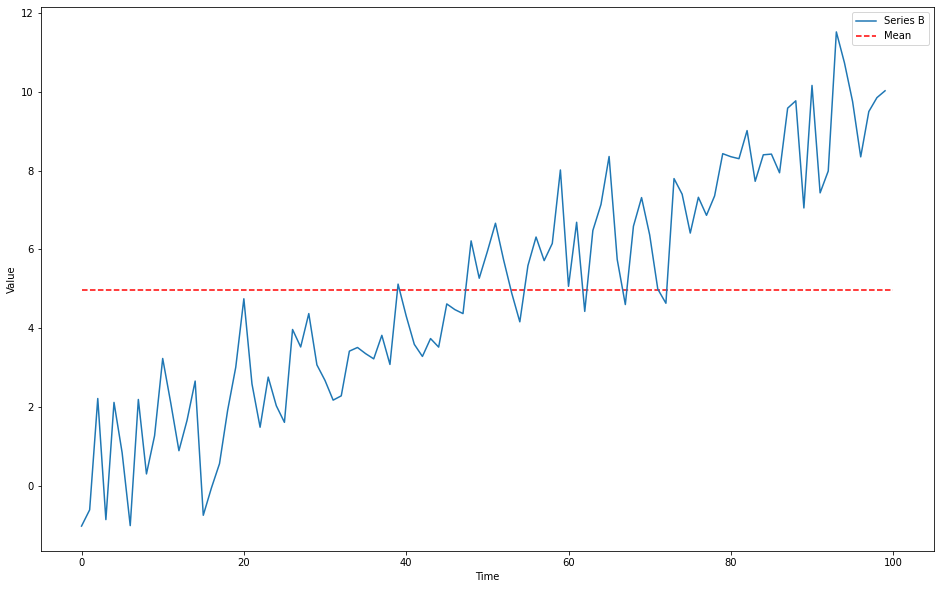

In [ ]:
plt.rcParams['figure.figsize'] = 16, 10
m = np.mean(B)

plt.plot(B)
plt.hlines(m, 0, len(B), linestyles='dashed', colors='r')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series B', 'Mean']);

The computed mean will show the mean of all data points, but won't be useful for any forecasting of future state. It's meaningless when compared with any specfic time, as it's a collection of different states at different times mashed together. This is just a simple and clear example of why non-stationarity can screw with analysis, much more subtle problems can arise in practice.

###Testing for Stationarity

Now we want to check for stationarity using a statistical test.

In [ ]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
        return True
    else:
        print ('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')
        return False

In [ ]:
check_for_stationarity(A);
check_for_stationarity(B);

p-value = 9.53594663282014e-20 The series A is likely stationary.
p-value = 0.9321183063241457 The series B is likely non-stationary.


Sure enough, the changing mean of the series makes it non-stationary. Let's try an example that might be a little more subtle.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


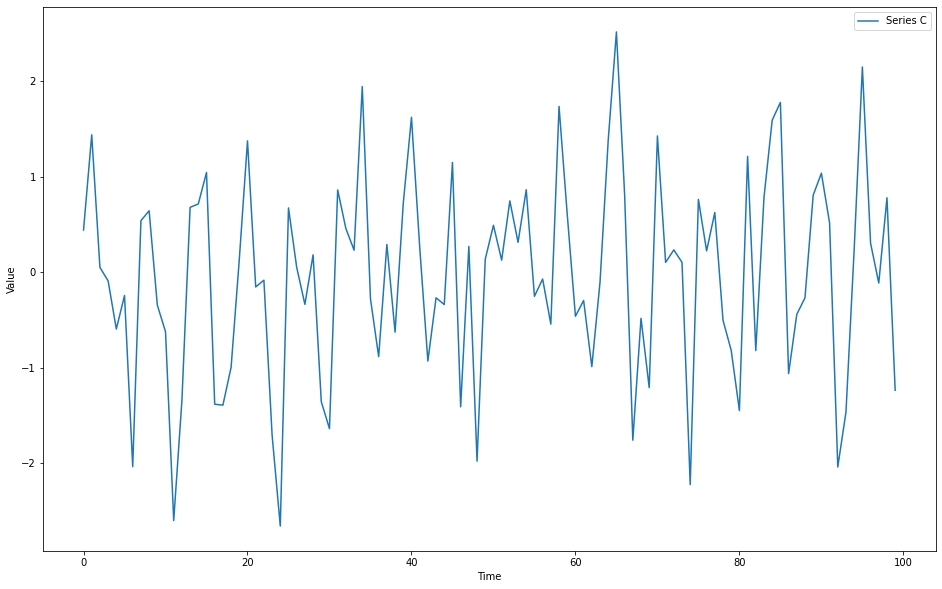

In [ ]:
# Set the number of datapoints
T = 100

C = pd.Series(index=range(T))
C.name = 'C'

for t in range(T):
    # Now the parameters are dependent on time
    # Specifically, the mean of the series changes over time
    params = (np.sin(t), 1)
    C[t] = generate_datapoint(params)

plt.plot(C)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series C']);

A cyclic movement of the mean will be very difficult to tell apart from random noise. In practice on noisy data and limited sample size it can be hard to determine if a series is stationary and whether any drift is random noise or part of a trend. In each individual case the test may or may not pick up subtle effects like this.

In [ ]:
check_for_stationarity(C);

p-value = 0.014986132175201183 The series C is likely non-stationary.


# Order of Inegration
## Example Return on a stock are normally distributed -> Order of Integration Zero 
## Order of Integration One on stock Return is Price 

Let's take our original stationary series A. Because A is stationary, we know it's also $I(0)$.

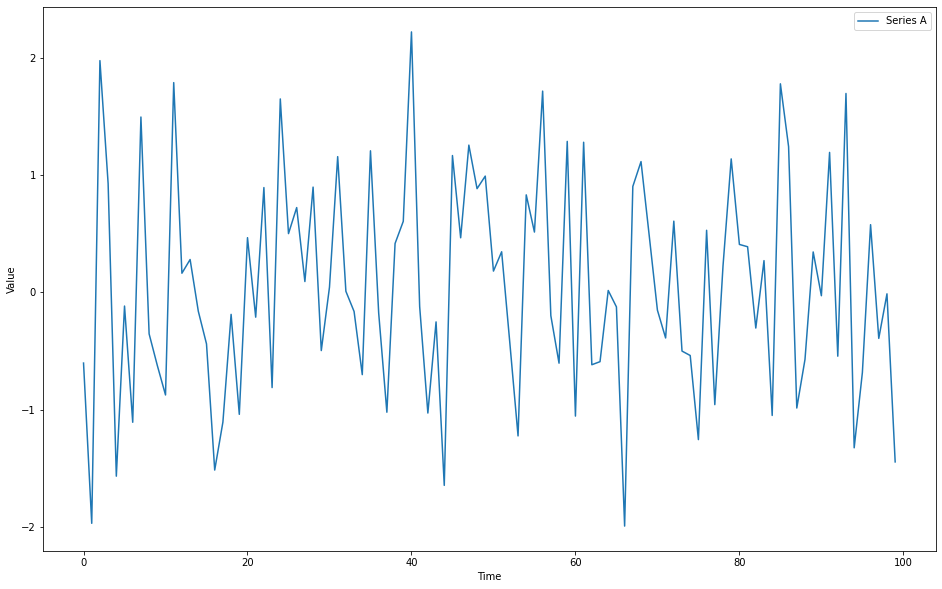

In [ ]:
plt.plot(A)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A']);

###Inductively Building Up Orders of Integration

If one takes an $I(0)$ series and cumulatively sums it (discrete integration), the new series will be $I(1)$. Notice how this is related to the calculus concept of integration. The same relation applies in general, to get $I(n)$ take an $I(0)$ series and iteratively take the cumulative sum $n$ times.

Now let's make an $I(1)$ series by taking the cumulative sum of A.

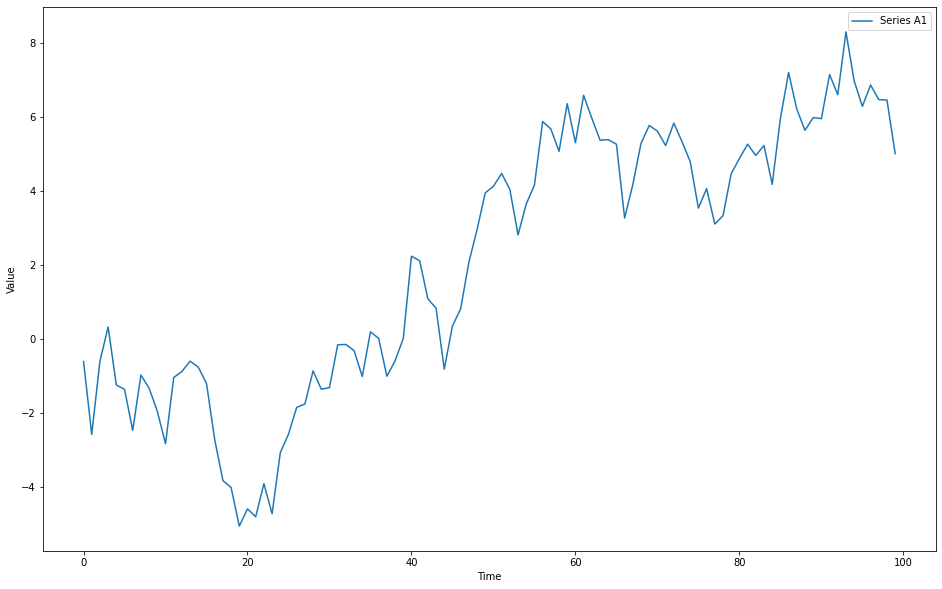

In [ ]:
A1 = np.cumsum(A)

plt.plot(A1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A1']);

Now let's make one $I(2)$ by taking the cumlulative sum again.

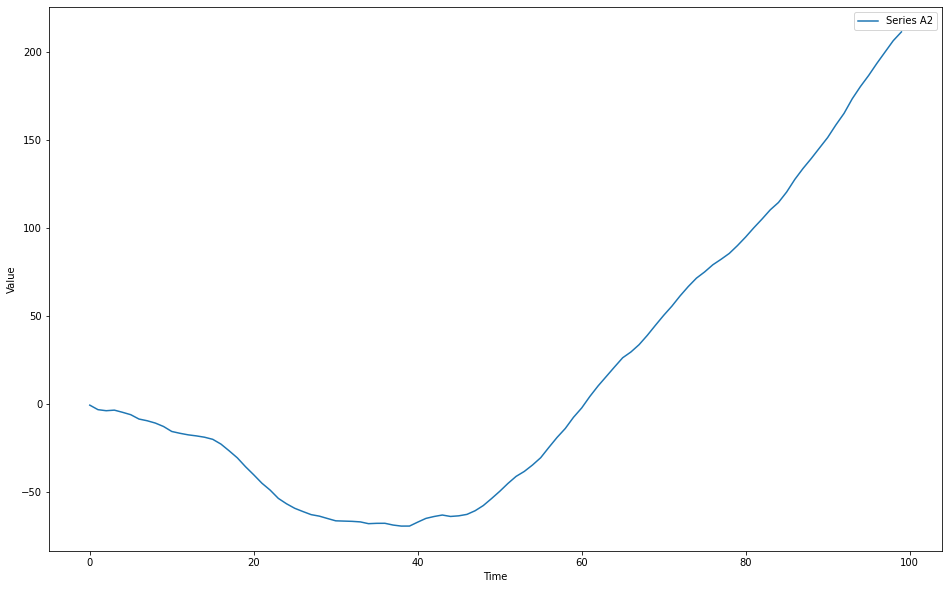

In [ ]:
A2 = np.cumsum(A1)

plt.plot(A2)
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['Series A2']);

###Breaking Down Orders of Integration

Conversely, to find the order of integration of a given series, we perform the inverse of a cumulative sum, which is the $\Delta$ or itemwise difference function. Specifically

$$(1-L) X_t = X_t - X_{t-1} = \Delta X$$

$$(1-L)^d X_t$$

In this case $L$ is the lag operator. Sometimes also written as $B$ for 'backshift'. $L$ fetches the second to last elements in a time series, and $L^k$ fetches the k-th to last elements. So 

$$L X_t = X_{t-1}$$

and

$$(1-L) X_t = X_t - X_{t-1}$$

A series $Y_t$ is $I(1)$ if the $Y_t - Y_t-1$ is $I(0)$. In other words, if you take an $I(0)$ series and cumulatively sum it, you should get an $I(1)$ series.


###Important Take-Away

Once all the math has settled, remember that any stationary series is $I(0)$

# Every Time series with Order of Integration 0 is not Stationary
# Every Time series which is Stationary has 0 Order of Integration
# Every time series with Order of Integration > 0 cannot be stationary
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
msft = pd.read_csv('/content/drive/My Drive/NYU/AlgoTrading-Summer-2022/MSFT.csv')

In [ ]:
X = msft['Adj Close']

In [ ]:
check_for_stationarity(X)

p-value = 0.467050905374529 The series Adj Close is likely non-stationary.


False

Let's take a look, certainly has the warning signs of a non-stationary series.

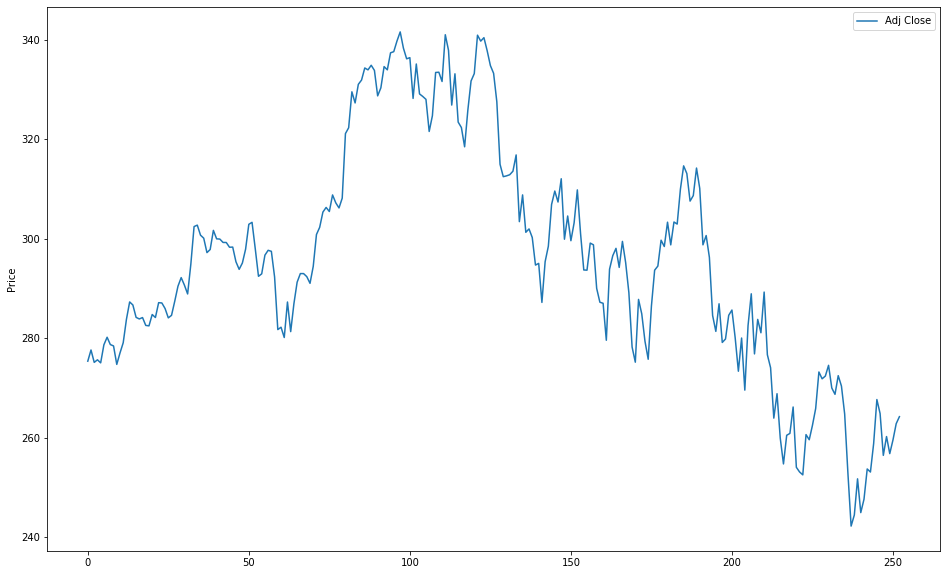

In [ ]:
plt.plot(X.index, X.values)
plt.ylabel('Price')
plt.legend([X.name]);

Now let's take the delta of the series, giving us the additive returns. We'll check if this is stationary.

p-value = 8.8133198066665e-30 The series Adj Close Additive Returns is likely stationary.


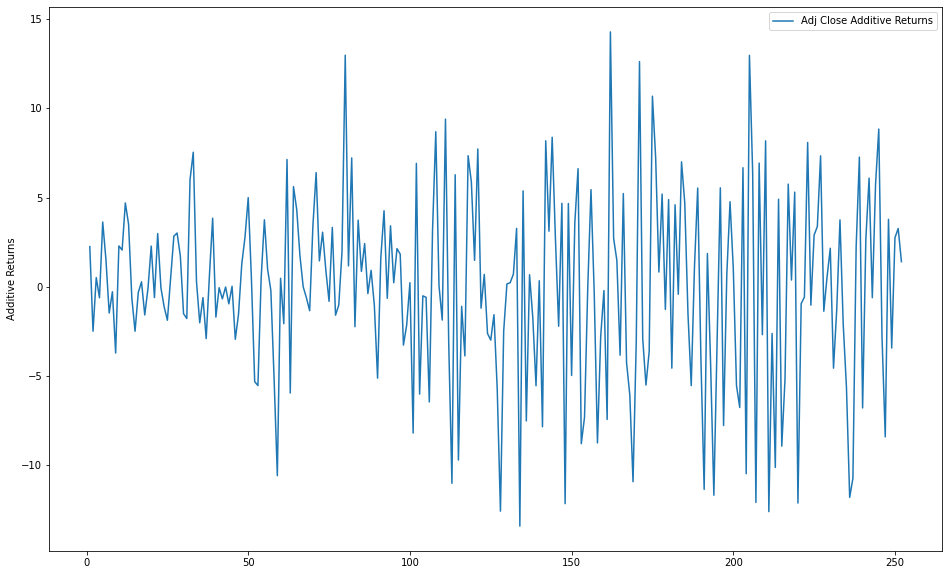

In [ ]:
X1 = X.diff()[1:]
X1.name = X.name + ' Additive Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Additive Returns')
plt.legend([X1.name]);

Seems like the additive returns are stationary over last five years. That means we will probably be able to model the returns much better than the price. It also means that the price was 𝐼(1).

Let's also check the multiplicative returns.

p-value = 8.905108501471452e-30 The series Adj Close Multiplicative Returns is likely stationary.


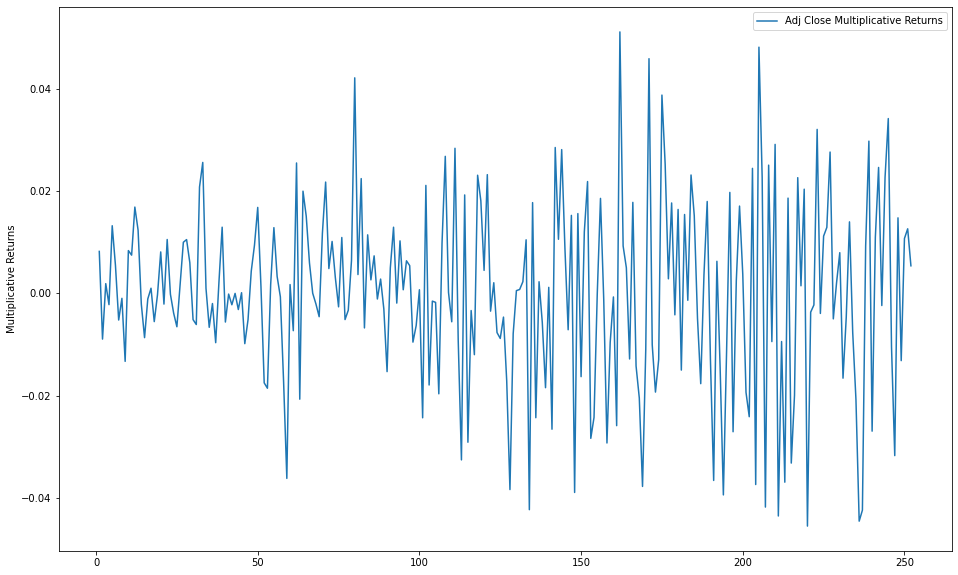

In [ ]:
X1 = X.pct_change()[1:]
X1.name = X.name + ' Multiplicative Returns'
check_for_stationarity(X1)
plt.plot(X1.index, X1.values)
plt.ylabel('Multiplicative Returns')
plt.legend([X1.name]);

Seems like the multiplicative returns are also stationary. Both the multiplicative and additive deltas on a series get at similar pieces of information, so it's not surprising both are stationary. In practice this might not always be the case.

##IMPORTANT NOTE

As always, you should not naively assume that because a time series is stationary in the past it will continue to be stationary in the future. Tests for consistency of stationarity such as cross validation and out of sample testing are necessary. This is true of any statistical property, we just reiterate it here. Returns may also go in and out of stationarity, and may be stationary or non-stationary depending on the timeframe and sampling frequency.



##Note: Returns Analysis

The reason returns are usually used for modeling in quantitive finance is that they are far more stationary than prices. This makes them easier to model and returns forecasting more feasible. Forecasting prices is more difficult, as there are many trends induced by their $I(1)$ integration. Even using a returns forecasting model to forecast price can be tricky, as any error in the returns forecast will be magnified over time.

##Cointegration

Finally, now that we've discussed stationarity and order of integration, we can discuss cointegration.

###Def: Linear Combination

A linear combination of the time series ($X_1$, $X_2$, $\dots$, $X_k$) is a new time series $Y$ constructed as follows for any set of real numbers $b_1 \dots b_k$

$$Y = b_1X_1 + b_2X_2 + \dots + b_kX_k$$

###Formal Definition

The formal definition of cointegration is as follows.


For some set of time series ($X_1$, $X_2$, $\dots$, $X_k$), if all series are $I(1)$, and some linear combination of them is $I(0)$, we say the set of time series is cointegrated.

####Example

$X_1$, $X_2$, and $X_3$ are all $I(1)$, and $2X_1 + X_2 + 0X_3 = 2X_1 + X_2$ is $I(0)$. In this case the time series are cointegrated.

###Intuition

The intuition here is that for some linear combination of the series, the result lacks much auto-covariance and is mostly noise. This is useful for cases such as pairs trading, in which we find two assets whose prices are cointegrated. Since the linear combination of their prices $b_1A_1 + b_2A_2$ is noise, we can bet on the relationship $b_1A_1 + b_2A_2$ mean reverting and place trades accordingly. 

A drunk man leaves the pub with his dog.

 

He forgets to put a leash on his dog, and so he and the dog begin to stumble home. Eventually, they reach a crosswalk, and realizing his dog is untethered, the drunk man leashes his dog before crossing the road.

The dog and the man cross the road, and walk awhile toward his brownstone. Eventually the dog realizes they are almost home and the dog begins tugging strongly at the leash, effectively pulling the man the final few yards to home.

***What does this tell us about correlation, cointegration, and causal relationships?***

When the man and the dog first leave the pub, their paths are correlated. They generally move in the same direction, but the distance between the dog and the man has no actual limit. It increases at times, decreases at times, but is generally random and poorly defined. The direction of the two, however, is generally the same.

When the man leashes his dog, they become cointegrated. Now, while their direction is still the same, their distance from one another is finite. The dog cannot move beyond the length of the leash from the man.

Finally, when the dog begins pulling the man home, the two become causal. You can fully explain the path of the man if you know the path of the dog.

True cointegration is rare. It means that two things are “tethered” together somehow. It is a more powerful understanding of a thing, however, and can give you more insight than correlation can. The point is that not everything can be described by a cointegration relationship.

Correlation is the most common metric for risk, because any two things can be described with a correlation statistic. You can correlate elephant migration patterns with stock prices. They may not be linked, but they can be described by a correlation statistic.

 

 

We willl see the difference between cointegration and correlation through definitions, graphs, and mathematical formulas.

Definitions

Cointegration

1.    It is whether the spread between two instruments is stationary

2.    It applies to long-term properties of time series

Correlation

1.    It is whether the two instruments returns move in the same direction

2.    It is associated with either short-term or long-term properties of time series

Visual explanation

Correlation without Cointegration

In the below graph, the Stock X and Stock Y are moving in same direction. Hence, they are correlated.

The spread between the price of two stocks has increased from 0 to 100. Thus, they are not cointegrated.

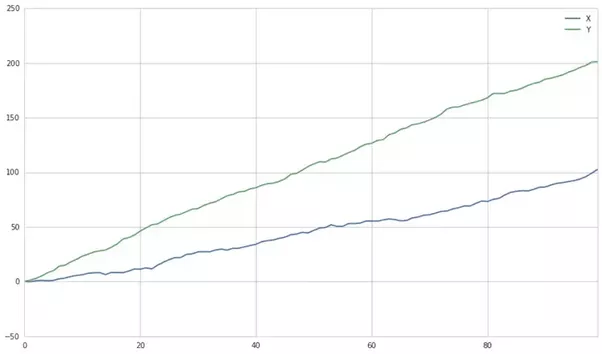

Cointegrated without Correlation

In the below graph, the spread between the price of two stocks moves from positive to zero, from zero to negative and so on. Thus, the stocks are cointegrated.

However, the Stock Y (blue) moves up and down but the Stock X (green) hardly changes. Hence, they are not correlated.

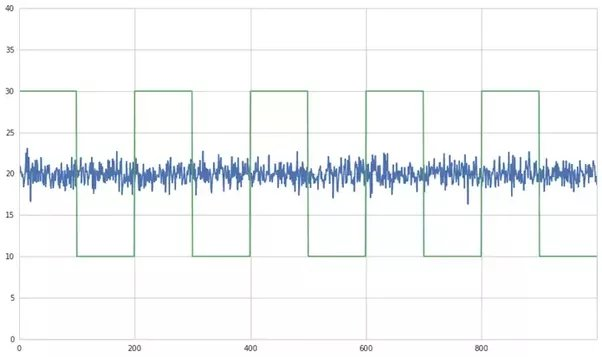

Correlation

The correlation coefficient of two stocks X and Y is defined as

r=Cov(X,Y)/std(X).std(Y)r=Cov(X,Y)/std(X).std(Y)

where,

CovCov is the covariance

stdstd is the standard deviation

Cointegration

If there exists a relationship between two non-stationary I(1) series, Y and X , such that the residuals of the regression are stationary, then the variables in question are said to be cointegrated.

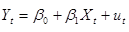

In other words, if

Screen Shot 2022-07-06 at 1.35.52 PM.png

is stationary, then, X and Y are cointegrated.

The property of cointegration is primarily used in pairs trading and to form cointegrated portfolios.



###Simulated Data Example

Let's make some data to demonstrate this.

In [ ]:
# Length of series
N = 100

# Generate a stationary random X1
X1 = np.random.normal(0, 1, N)
# Integrate it to make it I(1)
X1 = np.cumsum(X1)
X1 = pd.Series(X1)
X1.name = 'X1'

# Make an X2 that is X1 plus some noise
X2 = X1 + np.random.normal(0, 1, N)
X2.name = 'X2'

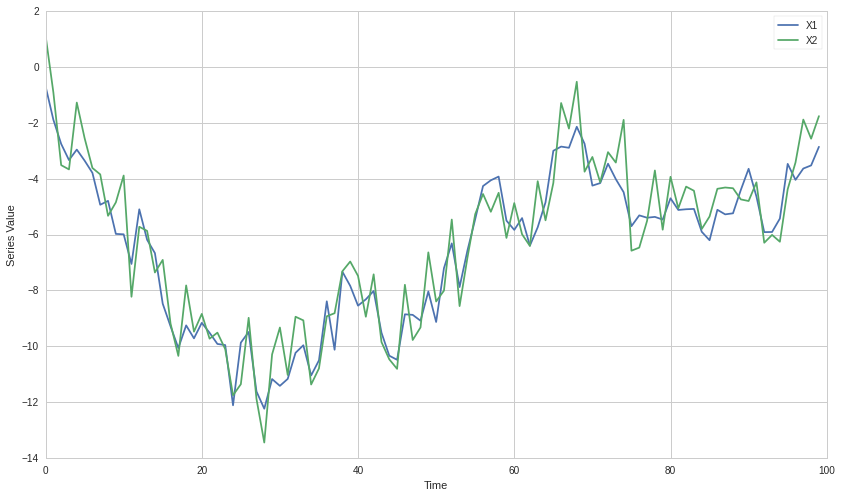

In [ ]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

Because $X_2$ is just an $I(1)$ series plus some stationary noise, it should still be $I(1)$. Let's check this.

In [ ]:
Z = X2.diff()[1:]
Z.name = 'Z'

check_for_stationarity(Z);

p-value = 3.06566830522e-19 The series Z is likely stationary.


Looks good. Now to show cointegration we'll need to find some linear combination of $X_1$ and $X_2$ that is stationary. We can take $X_2-X_1$. All that's left over should be stationary noise by design. Let's check this.

p-value = 1.03822288113e-18 The series Z is likely stationary.


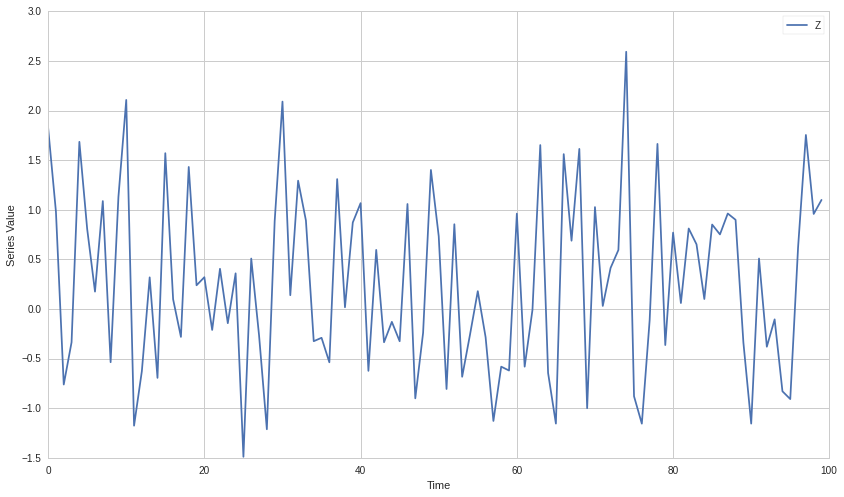

In [ ]:
Z = X2 - X1
Z.name = 'Z'

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Z']);

check_for_stationarity(Z);

###Testing for Cointegration

There are a bunch of ways to test for cointegration. This [wikipedia article](https://en.wikipedia.org/wiki/Cointegration) describes some. In general we're just trying to solve for the coefficients $b_1, \dots b_k$ that will produce an $I(0)$ linear combination. If our best guess for these coefficients does not pass a stationarity check, then we reject the hypothesis that the set is cointegrated. This will lead to risk of Type II errors (false negatives), as we will not exhaustively test for stationarity on all coefficent combinations. However Type II errors are generally okay here, as they are safe and do not lead to us making any wrong forecasts.

In practice a common way to do this for pairs of time series is to use linear regression to estimate $\beta$ in the following model.

$$X_2 = \alpha + \beta X_1 + \epsilon$$

The idea is that if the two are cointegrated we can remove $X_2$'s depedency on $X_1$, leaving behind stationary noise. The combination $X_2 - \beta X_1 = \alpha + \epsilon$ should be stationary.

####Real Data Example

Task 1: try on some real data. 
For the example in the class we will use two names - Visa and Master Card


In [ ]:
V = pd.read_csv('/content/drive/My Drive/NYU/AlgoTrading-Summer-2022/V.csv')
MA = pd.read_csv('/content/drive/My Drive/NYU/AlgoTrading-Summer-2022/MA.csv')

In [ ]:
X1 = V['Adj Close']
X2 = MA['Adj Close']

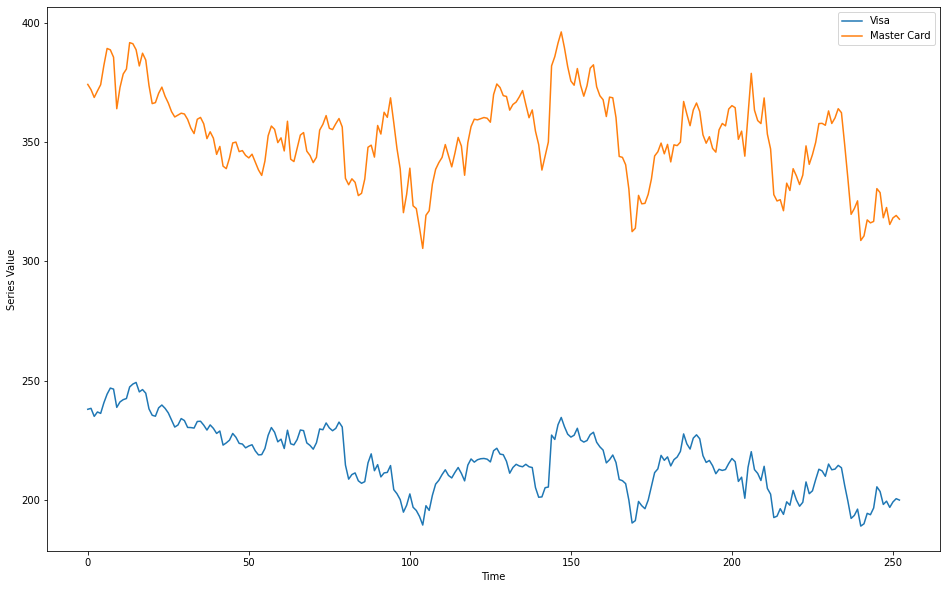

In [ ]:
plt.plot(X1)
plt.plot(X2)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend(['Visa', 'Master Card']);

# Correlation Trading 
## ETF TRading - Percentage Variation of ETF price can be explained by variation of price in few of the components 
## That means the few components have strong correlation with ETF
## The index of few components can be a leading indicator for ETF

Now use linear regression to compute $\beta$.

In [ ]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()
results.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const        116.346453
Adj Close      1.086164
dtype: float64

p-value = 0.13341310311803883 The series Adj Close is likely non-stationary.


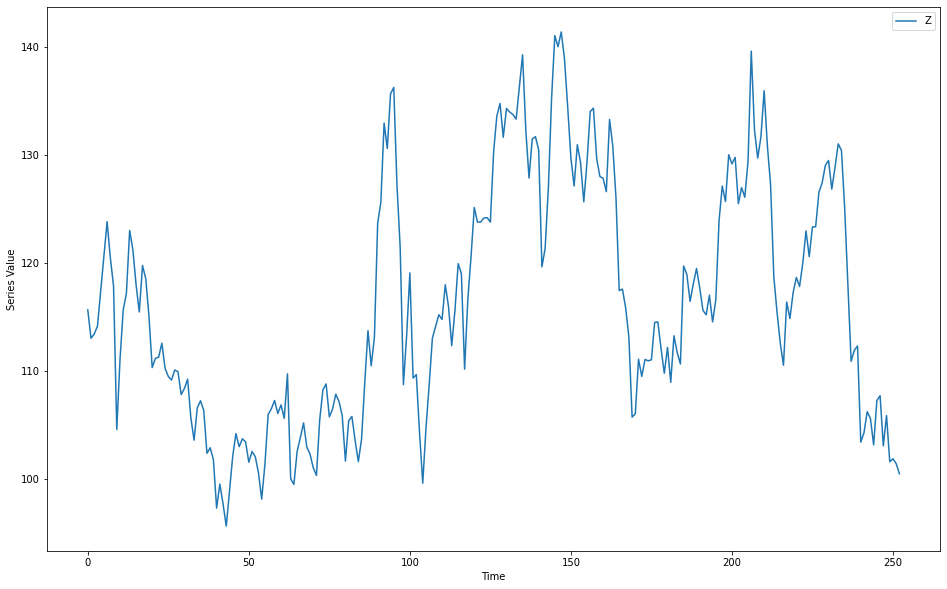

In [ ]:
b = results.params['Adj Close']
#print (b)
#print (X2)
#print (b *X1)
X2B = b * X1
Z = X2 - X2B['Adj Close']

plt.plot(Z)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend('Z');

check_for_stationarity(Z);

We can see here that the resulting 𝑍 was likely not stationary over the time frame we looked at. This causes us to reject the hypothesis that our two assets were cointegrated over the same timeframe.

#This is only a forecast!

Remember as with anything else, you should not assume that because some set of assets have passed a cointegration test historically, they will continue to remain cointegrated. You need to verify that consistent behavior occurs, and use various model validation techniques as you would with any model.

One of the most important things done in finance is to make many independent bets. Here a quant would find many pairs of assets they hypothesize are cointegrated, and evenly distribute their dollars between them in bets. This only requires more than half of the asset pairs to remain cointegrated for the strategy to work. 

###Existing Tests

Luckily there are some pre-built tests for cointegration. Here's one. Read up on the [documentation](http://statsmodels.sourceforge.net/devel/_modules/statsmodels/tsa/stattools.html) on your own time.

In [ ]:
from statsmodels.tsa.stattools import coint

coint(X1['Adj Close'], X2)


(-1.711954544632553,
 0.6714211499311837,
 array([-3.94042787, -3.36048387, -3.06132299]))

p value is high - so not cointegrated.
<br>
Ref:
[Statsmodels-coint](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html)

#Assignment Pairs Trading - could be your first project
# Use a ranking algo to select universe of 50 stocks from universe of S&P500
# Use one historical data to identify the pairs
# Take a fix portfolio amount and trade at open and close on the identified pair 
# Trade for the month 
# Tabulate your performance 

#Current Topic 
## Inflation Expectation

[Paul Krugman on Twitter](https://twitter.com/paulkrugman/status/1544680284234436608)

[Inflation Index Estimation by ICE](https://www.ice.com/iba/usd-inflation-indexes)

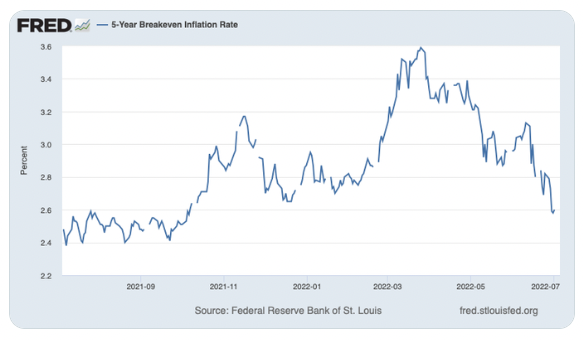


[CME Fed watch tool ](https://www.cmegroup.com/trading/interest-rates/countdown-to-fomc.html)